In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"C:\Users\domma\Dropbox\Software\CognitiveModels\content"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]


ERROR: LoadError: 

MethodError: no method matching to_rotation(::Nothing)

Closest candidates are:
  to_rotation(::Makie.Quaternionf)
   @ Makie C:\Users\domma\.julia\packages\Makie\rEu75\src\conversions.jl:1245
  to_rotation(::Tuple{Union{Tuple{Vararg{T, N}}, StaticArraysCore.StaticArray{Tuple{N}, T, 1}} where {N, T}, Number})
   @ Makie C:\Users\domma\.julia\packages\Makie\rEu75\src\conversions.jl:1260
  to_rotation(::Union{Tuple{Vararg{T, N}}, StaticArraysCore.StaticArray{Tuple{N}, T, 1}} where T) where N
   @ Makie C:\Users\domma\.julia\packages\Makie\rEu75\src\conversions.jl:1248
  ...

Stacktrace:
  [1] to_2d_rotation(x::Nothing)
    @ CairoMakie C:\Users\domma\.julia\packages\CairoMakie\W0SZK\src\utils.jl:76
  [2] draw_marker(ctx::Cairo.CairoContext, beziermarker::Makie.BezierPath, pos::GeometryBasics.Vec{2, Float32}, scale::GeometryBasics.Vec{2, Float32}, strokecolor::ColorTypes.RGBA{Float32}, strokewidth::Float32, marker_offset::GeometryBasics.Vec{2, Float32}, rotation::Nothing)
    @ CairoMakie

In [2]:
#| code-fold: false

using Downloads, CSV, DataFrames, Random
using Turing, Distributions, StatsFuns, SubjectiveScalesModels
using GLMakie

Random.seed!(123)  # For reproducibility

df = CSV.read(Downloads.download("https://raw.githubusercontent.com/DominiqueMakowski/CognitiveModels/main/data/wagenmakers2008.csv"), DataFrame)

# Show 10 first rows
first(df, 10)

Row,Participant,Condition,RT,Error,Frequency
,Int64,String15,Float64,Bool,String15
1,1,Speed,0.7,false,Low
2,1,Speed,0.392,true,Very Low
3,1,Speed,0.46,false,Very Low
4,1,Speed,0.455,false,Very Low
5,1,Speed,0.505,true,Low
6,1,Speed,0.773,false,High
7,1,Speed,0.39,false,High
8,1,Speed,0.587,true,Low
9,1,Speed,0.603,false,Low


In [3]:
#| code-fold: false

combine(groupby(df, :Condition), :Error => mean)

Row,Condition,Error_mean
,String15,Float64
1,Speed,0.110407
2,Accuracy,0.0451463


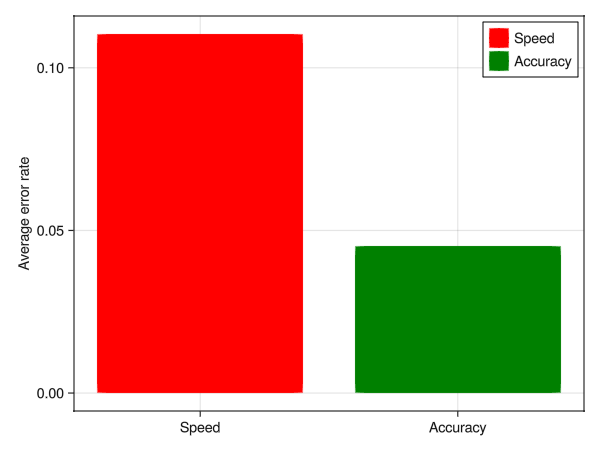

In [4]:
dat = combine(groupby(df, :Condition), :Error => mean)

fig = Figure()
ax = Axis(fig[1, 1], ylabel="Average error rate", xticks =([0, 1], ["Speed", "Accuracy"]))
barplot!(ax, [0], [dat.Error_mean[1]], label="Speed", color=:red)
barplot!(ax, [1], [dat.Error_mean[2]], label="Accuracy", color=:green)
axislegend()
fig

In [5]:
#| code-fold: false

df.Accuracy = ifelse.(df.Condition .== "Accuracy", 1, 0)

10369-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [6]:
#| code-fold: false
#| output: false

@model function model_logistic(y; condition=df.Accuracy)
    # Priors
    p_intercept ~ Normal(0, 1)
    p_condition ~ Normal(0, 1)
    
    # Likelihood
    for i in 1:length(y)
        # Linear model equation
        p = p_intercept + p_condition * condition[i]
        
        # Inference
        y[i] ~ BernoulliLogit(p)
    end
end

fit_logistic = model_logistic(df.Error, condition=df.Accuracy)
posteriors_logistic = sample(fit_logistic, NUTS(), 500)

┌ Info: Found initial step size
└   ϵ = 0.05


Sampling:   7%|███                                      |  ETA: 0:00:01

Sampling:  90%|██████████████████████████████████████   |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (500×14×1 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 1
Samples per chain = 500
Wall duration     = 7.26 seconds
Compute duration  = 7.26 seconds
parameters        = p_intercept, p_condition
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
   parameters      mean       std      mcse   ess_bulk   ess_tail      rhat    ⋯
       Symbol   Float64   Float64   Float64    Float64    Float64   Float64    ⋯

  p_intercept   -2.0898    0.0461    0.0027   284.3024   296.8910    1.0042    ⋯
  p_condition   -0.9587    0.0804    0.0052   244.7954   267.3729    1.0022    ⋯
                                                                1 column omitted

Quantiles
   parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
       Symbol   Float64   Float64   Float64   Float64   Fl

In [7]:
#| code-fold: false

# 95% CI
hpd(posteriors_logistic)

HPD
   parameters     lower     upper 
       Symbol   Float64   Float64 

  p_intercept   -2.1812   -2.0035
  p_condition   -1.0957   -0.8047


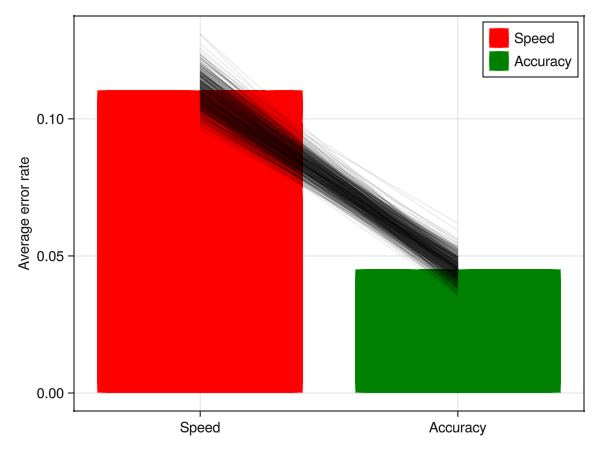

In [8]:
#| output: false

pred = predict(model_logistic(fill(missing, length(df.Error)), condition=df.Accuracy), posteriors_logistic)
pred = Array(pred)

for i in 1:length(posteriors_logistic)
    mean_speed = mean(pred[i, :][df.Accuracy .== 0])
    mean_accuracy = mean(pred[i, :][df.Accuracy .== 1])
    lines!([0, 1], [mean_speed, mean_accuracy], color=(:black, 0.1), linewidth=1)
end

fig

In [9]:
#| code-fold: false
#| output: false

@model function model_logistic(y; condition=df.Accuracy, participant=df.Participant)
    # Priors for  fixed effects
    p_intercept_fixed ~ Normal(0, 1)
    p_condition_fixed ~ Normal(0, 1)

    # Priors for the SD of the random effects 
    p_intercept_participant_sd ~ truncated(Normal(0, 0.5); lower=0)
    p_condition_participant_sd ~ truncated(Normal(0, 0.5); lower=0)

    # Priors for each participant
    p_intercept_participant ~ filldist(Normal(0, p_intercept_participant_sd), length(unique(participant)))
    p_condition_participant ~ filldist(Normal(0, p_condition_participant_sd), length(unique(participant)))
    
    # Likelihood
    for i in 1:length(y)
        # Random components
        p_intercept = p_intercept_fixed + p_intercept_participant[participant[i]]
        p_condition = p_condition_fixed + p_condition_participant[participant[i]]

        # Linear model equation
        p = p_intercept + p_condition * condition[i]
        
        # Inference
        y[i] ~ BernoulliLogit(p)
    end
end

fit_logistic = model_logistic(df.Error, condition=df.Accuracy, participant=df.Participant)
posteriors_logistic = sample(fit_logistic, NUTS(), 500)
# using MicroCanonicalHMC
# posteriors_logistic = sample(fit_logistic, externalsampler(MCHMC(1000, 0.001)), 500)

┌ Info: Found initial step size
└   ϵ = 0.025


Sampling:   2%|█                                        |  ETA: 0:00:10

Sampling:   2%|█                                        |  ETA: 0:00:16

Sampling:   3%|██                                       |  ETA: 0:00:17

Sampling:   4%|██                                       |  ETA: 0:00:16

Sampling:   4%|██                                       |  ETA: 0:00:17

Sampling:   5%|███                                      |  ETA: 0:00:17

Sampling:   6%|███                                      |  ETA: 0:00:17

Sampling:   7%|███                                      |  ETA: 0:00:18

Sampling:   8%|████                                     |  ETA: 0:00:17

Sampling:   9%|████                                     |  ETA: 0:00:16

Sampling:   9%|████                                     |  ETA: 0:00:17

Sampling:  10%|█████                                    |  ETA: 0:00:16

Sampling:  14%|██████                                   |  ETA: 0:00:15

Sampling:  15%|███████                                  |  ETA: 0:00:15

Sampling:  16%|███████                                  |  ETA: 0:00:15

Sampling:  16%|███████                                  |  ETA: 0:00:15

Sampling:  17%|████████                                 |  ETA: 0:00:15

Sampling:  18%|████████                                 |  ETA: 0:00:15

Sampling:  20%|█████████                                |  ETA: 0:00:14

Sampling:  21%|█████████                                |  ETA: 0:00:14

Sampling:  22%|█████████                                |  ETA: 0:00:14

Sampling:  23%|██████████                               |  ETA: 0:00:14

Sampling:  24%|██████████                               |  ETA: 0:00:13

Sampling:  26%|███████████                              |  ETA: 0:00:13

Sampling:  27%|███████████                              |  ETA: 0:00:13

Sampling:  28%|████████████                             |  ETA: 0:00:13

Sampling:  29%|████████████                             |  ETA: 0:00:12

Sampling:  30%|█████████████                            |  ETA: 0:00:12

Sampling:  31%|█████████████                            |  ETA: 0:00:12

Sampling:  32%|█████████████                            |  ETA: 0:00:12

Sampling:  33%|██████████████                           |  ETA: 0:00:11

Sampling:  34%|███████████████                          |  ETA: 0:00:11

Sampling:  36%|███████████████                          |  ETA: 0:00:11

Sampling:  37%|████████████████                         |  ETA: 0:00:10

Sampling:  38%|████████████████                         |  ETA: 0:00:10

Sampling:  39%|█████████████████                        |  ETA: 0:00:10

Sampling:  40%|█████████████████                        |  ETA: 0:00:09

Sampling:  44%|███████████████████                      |  ETA: 0:00:08

Sampling:  46%|███████████████████                      |  ETA: 0:00:08

Sampling:  47%|████████████████████                     |  ETA: 0:00:08

Sampling:  48%|████████████████████                     |  ETA: 0:00:08

Sampling:  49%|█████████████████████                    |  ETA: 0:00:08

Sampling:  50%|█████████████████████                    |  ETA: 0:00:07

Sampling:  51%|█████████████████████                    |  ETA: 0:00:07

Sampling:  53%|██████████████████████                   |  ETA: 0:00:07

Sampling:  54%|███████████████████████                  |  ETA: 0:00:07

Sampling:  56%|███████████████████████                  |  ETA: 0:00:06

Sampling:  57%|████████████████████████                 |  ETA: 0:00:06

Sampling:  58%|████████████████████████                 |  ETA: 0:00:06

Sampling:  60%|█████████████████████████                |  ETA: 0:00:06

Sampling:  62%|██████████████████████████               |  ETA: 0:00:05

Sampling:  63%|██████████████████████████               |  ETA: 0:00:05

Sampling:  64%|███████████████████████████              |  ETA: 0:00:05

Sampling:  66%|███████████████████████████              |  ETA: 0:00:05

Sampling:  67%|████████████████████████████             |  ETA: 0:00:05

Sampling:  68%|█████████████████████████████            |  ETA: 0:00:04

Sampling:  69%|█████████████████████████████            |  ETA: 0:00:04

Sampling:  70%|█████████████████████████████            |  ETA: 0:00:04

Sampling:  72%|██████████████████████████████           |  ETA: 0:00:04

Sampling:  73%|██████████████████████████████           |  ETA: 0:00:04

Sampling:  75%|███████████████████████████████          |  ETA: 0:00:03

Sampling:  76%|████████████████████████████████         |  ETA: 0:00:03

Sampling:  77%|████████████████████████████████         |  ETA: 0:00:03

Sampling:  78%|█████████████████████████████████        |  ETA: 0:00:03

Sampling:  80%|█████████████████████████████████        |  ETA: 0:00:03

Sampling:  82%|██████████████████████████████████       |  ETA: 0:00:02

Sampling:  83%|███████████████████████████████████      |  ETA: 0:00:02

Sampling:  84%|███████████████████████████████████      |  ETA: 0:00:02

Sampling:  86%|████████████████████████████████████     |  ETA: 0:00:02

Sampling:  88%|█████████████████████████████████████    |  ETA: 0:00:02

Sampling:  89%|█████████████████████████████████████    |  ETA: 0:00:01

Sampling:  90%|██████████████████████████████████████   |  ETA: 0:00:01

Sampling:  91%|██████████████████████████████████████   |  ETA: 0:00:01

Sampling:  92%|██████████████████████████████████████   |  ETA: 0:00:01

Sampling:  94%|███████████████████████████████████████  |  ETA: 0:00:01

Sampling:  95%|████████████████████████████████████████ |  ETA: 0:00:01

Sampling:  96%|████████████████████████████████████████ |  ETA: 0:00:01

Sampling:  97%|████████████████████████████████████████ |  ETA: 0:00:00

Sampling:  98%|█████████████████████████████████████████|  ETA: 0:00:00

Sampling:  99%|█████████████████████████████████████████|  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:13


Chains MCMC chain (500×28×1 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 1
Samples per chain = 500
Wall duration     = 19.93 seconds
Compute duration  = 19.93 seconds
parameters        = p_intercept_fixed, p_condition_fixed, p_intercept_participant_sd, p_condition_participant_sd, p_intercept_participant[1], p_intercept_participant[2], p_intercept_participant[3], p_intercept_participant[4], p_intercept_participant[5], p_intercept_participant[6], p_condition_participant[1], p_condition_participant[2], p_condition_participant[3], p_condition_participant[4], p_condition_participant[5], p_condition_participant[6]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
                  parameters      mean       std      mcse   ess_bulk   ess_ta ⋯
                      Symbol   Float64   Float64   Fl